# Using a Stewart Platform as a Motion Simulator
#### Python + ESP32 + 3D CAD + Motion Capture Data

This is a WIP progress!


[<img src="./doc/jupyter_nb/Stewart_IRL_1.gif" width="30%" height="30%">](./doc/jupyter_nb/Stewart_IRL_1.gif)
[<img src="./doc/jupyter_nb/Fusion360.png" width="30%" height="30%">](./doc/jupyter_nb/Fusion360.png)
[<img src="./doc/jupyter_nb/Stewart_IRL_2.gif" width="30%" height="30%">](./doc/jupyter_nb/Stewart_IRL_2.gif)


Import the CSV file containing the positions of a body in 6DOF. A 2DOF example of a person running on a treadmill is provided, of which we scale into the form of

Yaw: Radians

Translation in Z axis: Centimeters scaled according to height of motion simulator

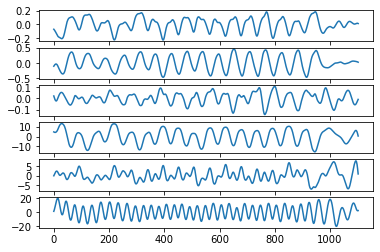

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

# file = open('positions_processed.csv')
# file = open('./motion_capture/relative_motion.csv')

file = open('./motion_capture/highknees_nn.csv')
csvreader = csv.reader(file)

rows = []
for row in csvreader:
        rows.append(row)
rows
file.close()
movements = np.array(rows).astype('float')
movements[:,0:3] = movements[:,0:3]/180*np.pi
movements[:,3:6] = movements[:,3:6]

plt.subplot(611); plt.plot(movements[:,0]) 
plt.subplot(612); plt.plot(movements[:,1])
plt.subplot(613); plt.plot(movements[:,2])
plt.subplot(614); plt.plot(movements[:,3]) 
plt.subplot(615); plt.plot(movements[:,4])
plt.subplot(616); plt.plot(movements[:,5])



My approach is then to
1. Use the stewart_py package to calculate the inverse kinematic of the desired position according to the movement data
2. Use py_serial to output the data to a ESP32
3. ESP32 receives serial data and issues I2C command to a pca9685
4. pca9685 commands 6 servo motors to rotate accordingly

This is a very cost efficient solution however if I could redo this project I'd use a Raspberry Pi instead and direcly use it to issue I2C commands to a pca9685

In [3]:
import numpy as np
from src.stewart_controller import Stewart_Platform
import matplotlib.pyplot as plt

import time
import serial


# Initialize serial

# ser = serial.Serial()
# ser.port = 'COM5'

# ser.baudrate = 38400
# ser.setDTR(False)
# ser.setRTS(False)

# # ser.close()

# if not ser.isOpen():
#     ser.open()

# Call object, 
# These parameters are for my 3D models as provided, you can change your parameters according to your own hardware,
# Stewart_Platform(r_B, r_P, lhl, ldl, Psi_B, Psi_P), where

# r_B = Radius of Base (Bottom)
# r_P = Radius of Platform (Top)
# lhl = Servo Horn Length
# ldl = Rod length
# Psi_B = Half of angle between two anchors on the base
# Psi_P = Half of angle between two anchors on the platform
# For details please refer to my tutorial https://github.com/Yeok-c/Stewart_Py

platform = Stewart_Platform(132/2, 175/2, 50.8, 130, 0.2269, 0.82, 5*np.pi/6)

controller_freq = 12
record_freq = 100
%matplotlib qt
# Initialize Plots
fig, ax = plt.subplots()    

while 1:
    # Loop through various angles
    for ix in range(0, np.shape(movements)[0], round(record_freq/controller_freq)):
        
        # time.sleep(1/controller_freq)
        # tic = time.time()
# [movements[ix,0], movements[ix,1], movements[ix,2]]
        # send servo angles for this time-step. Movement input data is scaled for better clarity, output is scaled into degrees

        # servo_angles = platform.calculate(np.array([movements[ix,3],movements[ix,4],movements[ix,5]-10]), np.array([-movements[ix,2],movements[ix,0],movements[ix,1]]))/np.pi*180
        # servo_angles = platform.calculate(movements[ix,3:6], np.array([movements[ix,0], movements[ix,1], movements[ix,2]]))/np.pi*180
        servo_angles = platform.calculate(movements[ix,3:6], np.array([movements[ix,0], 0, movements[ix,2]]))/np.pi*180


        # Send serial data to ESP32 in the form of a string "<A,float,float,float,float,float,float>"
        towrite = np.array2string(servo_angles, precision=1, separator=',').strip('[]')
        # towrite = '<A,' + towrite + '>'
        # ser.write(towrite.encode())     # write a string
        print(towrite)

        # Hide this if your computer takes too long to plot, affecting the controller speed

        VIEW = [[30, 76], [8, 0], [50, 50],[30, 90]]
        view_index = 1
        
        
        ax = platform.plot_platform()
        ax.view_init(elev=VIEW[1][0], azim=VIEW[1][1]) # Suitable angle
        plt.draw()

        # ax.view_init(elev=30., azim=76) # Suitable angle
        # ax.view_init(elev=8., azim=0) # Side view
        # ax.view_init(elev=50., azim=50) # Top/Side view
        # ax.view_init(elev=30., azim=90) # Top/Front view
        
        plt.pause(1/controller_freq)


        # toc = time.time()
        # print(tic-toc) # Measure time to see if plotting affects speed of controller


23.3,23.8,15.7,13.4,22.1,28. 
42.1,38.3,25.6,20.5,40. ,43.9
53. ,48.1,27. ,21.6,48.1,59.8
33. ,32.5,10.2, 3.3,29.1,44.6
24. ,24.9, 1.4,-6.4,20.9,36. 
36. ,36. ,25.6,19.4,35.1,43.4
32.5,31.4,38.8,36.7,32.8,31.4
13.9, 9.4,21.2,23.5,14.2, 3.5
 9.1, 5.2,16.5,21.1,10.3,-3.3
24.1,24.7,33.7,37.8,25.4,19.1
23.3,26.4,28. ,28.6,24.9,25.6
 8. ,10.2, 1.5,-2.1,10. ,10.8
10.9,13. , 4.5, 2.1,12.5,13.3
24. ,26.1,33.1,34.3,25.6,23.8
17.9,15.4,31.3,35.4,18.2, 9.2
  2.7, -3.3, 11.5, 19. ,  1.7,-12.5
 8.2, 5.1,20.5,28.2, 7.6,-2.9
25. ,25.5,37.9,42.9,24.6,22.2
20.9,21.4,24.2,25.2,20. ,22.8
 7.9, 6.7,-1.1,-4. , 6.2,10.8
16.4,16. , 6.9, 3.1,15. ,20.7
33.1,33.8,34.3,32. ,33.1,36.6
28.3,25.9,31. ,30.3,27.7,25.5
12.5, 8. ,11.4,12.7,11.5, 5.6
13.5,14.2,18.5,21.7,13.9,11.7
29.6,34.9,36.7,38.4,30.9,36.2
29.4,33.6,22.6,18.7,29.3,40.6
 19.2, 20.8, -4.4,-14.3, 18. , 29.8
26.1,27. , 5. ,-4.4,25.1,36. 
35.8,37. ,30.3,26.1,35.7,42.4
24.7,22.6,23.3,22.9,24.1,22.2
11. , 5.5, 6.1, 8.3,10.5, 1.3
19. ,14.3,17.7,19.3,19.1, 9.

In [ ]:
VIEW = [[30, 76], [8, 0], [50, 50],[30, 90]]
VIEW[0][0]

30

In [1]:
ix=1
import numpy as np
from src.stewart_controller import Stewart_Platform
import matplotlib.pyplot as plt       
platform = Stewart_Platform(132/2, 175/2, 50.8, 130, 0.2269, 0.82, 5*np.pi/6)
servo_angles = platform.calculate(np.array([0,0,0]), np.array([np.pi/6,0,0]))/np.pi*180

controller_freq = 12
%matplotlib qt
# Initialize Plots
fig, ax = plt.subplots()    
ax = platform.plot_platform()

plt.pause(1/controller_freq)
plt.draw()



# 76, 27

d:\Github\MCU_App\Stewart_Platform_Motion_Simulator\src\stewart_controller.py:134: RuntimeWarning: invalid value encountered in arcsin
  s.angles[k] = np.arcsin(g[k] / np.sqrt(e[k]**2 + fk**2)) - np.arctan2(fk,e[k])


TypeError: plot_platform() missing 1 required positional argument: 'global_trans'

In [ ]:

ser = serial.Serial()
ser.port = 'COM5'
ser.baudrate = 38400
ser.setDTR(False)
ser.setRTS(False)

# ser.close()
if not ser.isOpen():
    ser.open()


servo_angles = platform.calculate(np.array([0,0,0-2]), np.array([np.pi/5, 0,0]) )/np.pi*180

# Send serial data to ESP32 in the form of a string "<A,float,float,float,float,float,float>"
towrite = np.array2string(servo_angles, precision=1, separator=',').strip('[]')
towrite = '<A,' + towrite + '>'
ser.write(towrite.encode())     # write a string
print(towrite)
ax = platform.plot_platform()

plt.draw()

<A,-55.2,-23.4, 53.1, 53.1,-23.4,-55.2>


In [ ]:
import numpy as np
r_B, r_P, gamma_B, gamma_P = 6.2, 5, 0.2269, 0.82

# 0.2269rad is 13 degrees, which is standard gamma_B for stewart platforms

pi = np.pi
## Define the Geometry of the platform

# Psi_B (Polar coordinates)
psi_B = np.array([ 
    -gamma_B, 
    gamma_B,
    2*pi/3 - gamma_B, 
    2*pi/3 + gamma_B, 
    2*pi/3 + 2*pi/3 - gamma_B, 
    2*pi/3 + 2*pi/3 + gamma_B])

# psi_P (Polar coordinates)
# Direction of the points where the rod is attached to the platform.
psi_P = np.array([ 
    pi/3 + 2*pi/3 + 2*pi/3 + gamma_P,
    pi/3 + -gamma_P, 
    pi/3 + gamma_P,
    pi/3 + 2*pi/3 - gamma_P, 
    pi/3 + 2*pi/3 + gamma_P, 
    pi/3 + 2*pi/3 + 2*pi/3 - gamma_P])

# Coordinate of the points where servo arms 
# are attached to the corresponding servo axis.
B = r_B * np.array( [ 
    [ np.cos(psi_B[0]), np.sin(psi_B[0]), 0],
    [ np.cos(psi_B[1]), np.sin(psi_B[1]), 0],
    [ np.cos(psi_B[2]), np.sin(psi_B[2]), 0],
    [ np.cos(psi_B[3]), np.sin(psi_B[3]), 0],
    [ np.cos(psi_B[4]), np.sin(psi_B[4]), 0],
    [ np.cos(psi_B[5]), np.sin(psi_B[5]), 0] ])
B = np.transpose(B)
    
# Coordinates of the points where the rods 
# are attached to the platform.
P = r_P * np.array([ 
    [ np.cos(psi_P[0]),  np.sin(psi_P[0]), 0],
    [ np.cos(psi_P[1]),  np.sin(psi_P[1]), 0],
    [ np.cos(psi_P[2]),  np.sin(psi_P[2]), 0],
    [ np.cos(psi_P[3]),  np.sin(psi_P[3]), 0],
    [ np.cos(psi_P[4]),  np.sin(psi_P[4]), 0],
    [ np.cos(psi_P[5]),  np.sin(psi_P[5]), 0] ])
P = np.transpose(P)

print('6x3 array for Base anchors \n', B)

print('6x3 array for Platform anchors \n', P)

6x3 array for Base anchors 
 [[ 6.04108436  6.04108436 -1.8126619  -4.22842247 -4.22842247 -1.8126619 ]
 [-1.39474002  1.39474002  5.92910253  4.53436252 -4.53436252 -5.92910253]
 [ 0.          0.          0.          0.          0.          0.        ]]
6x3 array for Platform anchors 
 [[ 4.87150733  4.87150733 -1.46040129 -3.41110604 -3.41110604 -1.46040129]
 [-1.12623991  1.12623991  4.78196906  3.65572915 -3.65572915 -4.78196906]
 [ 0.          0.          0.          0.          0.          0.        ]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn

def plot_2D_annotate(X, Y):
    X = list(X)
    Y = list(Y)
    ax.plot(X,Y, 'or')  # Plot Points
    # Annotate Points
    for i, (xy) in enumerate(zip(X, Y)):                                 
        ax.annotate('Point ' + str(i) + '\n(%.5s, %.5s)' % xy, xy=xy, textcoords='data')

    X.append(X[0])
    Y.append(Y[0])
    ax.plot(X,Y)    # Plot lines

seaborn.set(style='ticks')
# plt.style.use('dark_background')

fig = plt.figure(figsize=(14, 6), dpi=80)

ax = fig.add_subplot(121)
ax.set_title('Base Anchors')
plot_2D_annotate(B[0,:], B[1,:])
circle_B = plt.Circle((0, 0), r_B, color='g', fill=False)
ax.add_patch(circle_B)

ax = fig.add_subplot(122)
ax.set_title('Platform Anchors')
plot_2D_annotate(P[0,:], P[1,:])
circle_r = plt.Circle((0, 0), r_P, color='g', fill=False)
ax.add_patch(circle_r)

plt.show()